Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The data set contains the following diseases:

Actinic keratosis

Basal cell carcinoma

Dermatofibroma

Melanoma

Nevus

Pigmented benign keratosis

Seborrheic keratosis

Squamous cell carcinoma

Vascular lesion

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

> mounting the dataset

In [19]:
# If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount("/content/gdrive")



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Importing all the important libraries

In [20]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [21]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/Colab Notebooks/01 Data set AI Ml new/Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')


In [22]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2240
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [23]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [24]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2240 files belonging to 9 classes.
Using 1792 files for training.


In [25]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2240 files belonging to 9 classes.
Using 448 files for validation.


In [26]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

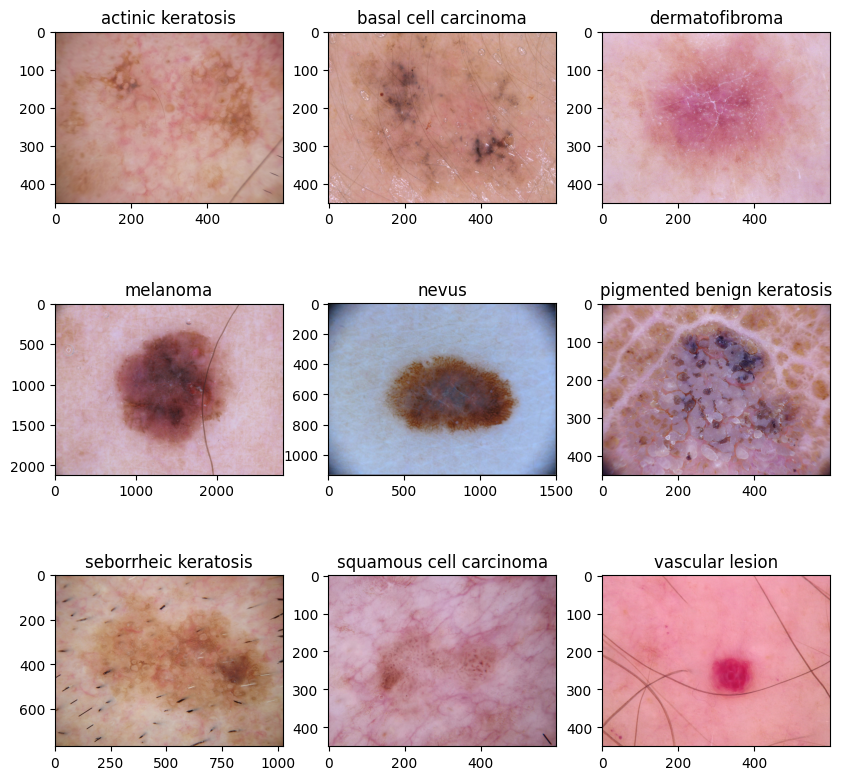

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
### your code goes here, you can use training or validation data to visualize
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [28]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

> Data set classes:


In [29]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,pigmented benign keratosis,462
2,vascular lesion,139
3,melanoma,439
4,nevus,357
5,dermatofibroma,95
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,basal cell carcinoma,376


<Axes: xlabel='No. of Image', ylabel='Class'>

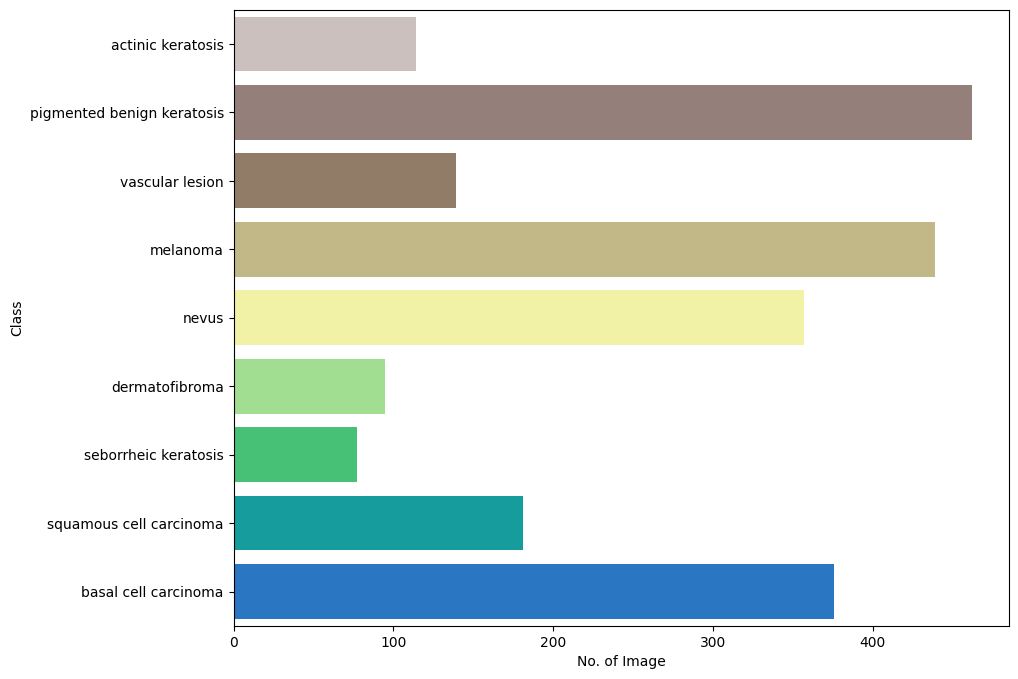

In [30]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class",hue='Class',palette='terrain_r')

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [31]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [32]:
losses = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [33]:
model.compile(optimizer='adam',
              loss=losses,
              metrics=['accuracy'])

In [34]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

### Train the model

In [35]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 26s 154ms/step - loss: 2.0598 - accuracy: 0.1875 - val_loss: 2.0420 - val_accuracy: 0.2054
Epoch 2/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0264 - accuracy: 0.1920 - val_loss: 2.0214 - val_accuracy: 0.2054
Epoch 3/20
56/56 [==============================] - 5s 90ms/step - loss: 2.0123 - accuracy: 0.1987 - val_loss: 1.9698 - val_accuracy: 0.2522
Epoch 4/20
56/56 [==============================] - 5s 91ms/step - loss: 2.0141 - accuracy: 0.2349 - val_loss: 2.0004 - val_accuracy: 0.2366
Epoch 5/20
56/56 [==============================] - 5s 92ms/step - loss: 1.9852 - accuracy: 0.2249 - val_loss: 2.0135 - val_accuracy: 0.2098
Epoch 6/20
56/56 [==============================] - 5s 89ms/step - loss: 1.9591 - accuracy: 0.2405 - val_loss: 1.9796 - val_accuracy: 0.2299
Epoch 7/20
56/56 [==============================] - 5s 90ms/step - loss: 2.0253 - accuracy: 0.2372 - val_loss: 1.9588 - val_accuracy: 0.2210
Epoch 8/20
56/56 [====

### Visualizing training results

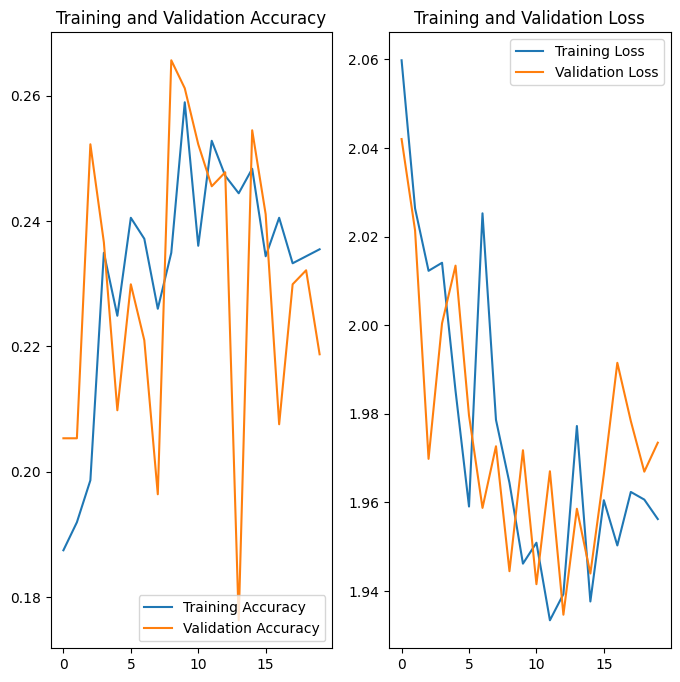

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Finding on the first base model

- The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch

- The accuracy is just around 75-80% because there are enough features to remember the pattern.

- But again, it's too early to comment on the overfitting & underfitting debate

### Write your findings here

In [37]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

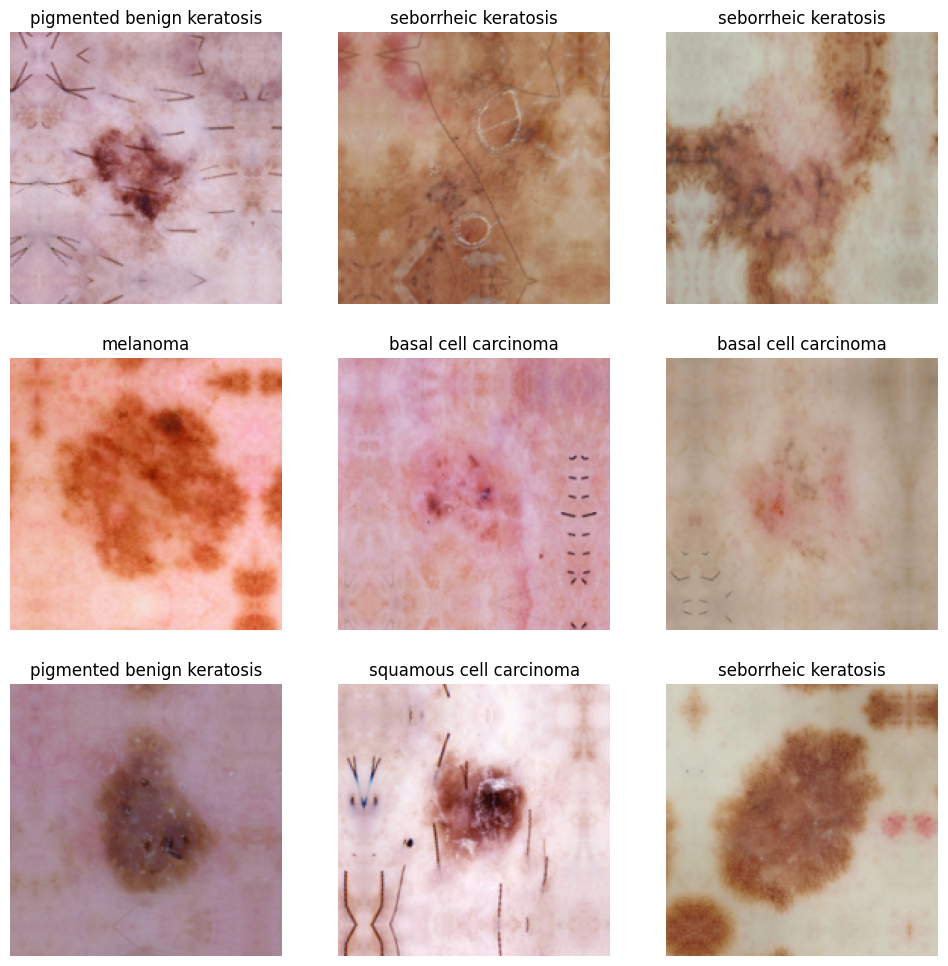

In [38]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [39]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [40]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [41]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 10s 106ms/step - loss: 2.0705 - accuracy: 0.2065 - val_loss: 2.0395 - val_accuracy: 0.2054
Epoch 2/20
56/56 [==============================] - 6s 103ms/step - loss: 2.0303 - accuracy: 0.1897 - val_loss: 2.0262 - val_accuracy: 0.1987
Epoch 3/20
56/56 [==============================] - 6s 102ms/step - loss: 2.0261 - accuracy: 0.1975 - val_loss: 2.0364 - val_accuracy: 0.2054
Epoch 4/20
56/56 [==============================] - 6s 102ms/step - loss: 2.0187 - accuracy: 0.2031 - val_loss: 2.0278 - val_accuracy: 0.2054
Epoch 5/20
56/56 [==============================] - 6s 101ms/step - loss: 2.0212 - accuracy: 0.1925 - val_loss: 2.0277 - val_accuracy: 0.2054
Epoch 6/20
56/56 [==============================] - 6s 102ms/step - loss: 2.0169 - accuracy: 0.2076 - val_loss: 2.0194 - val_accuracy: 0.2054
Epoch 7/20
56/56 [==============================] - 6s 102ms/step - loss: 2.0313 - accuracy: 0.1948 - val_loss: 2.0302 - val_accuracy: 0.2054
Epoch

### Visualizing the results

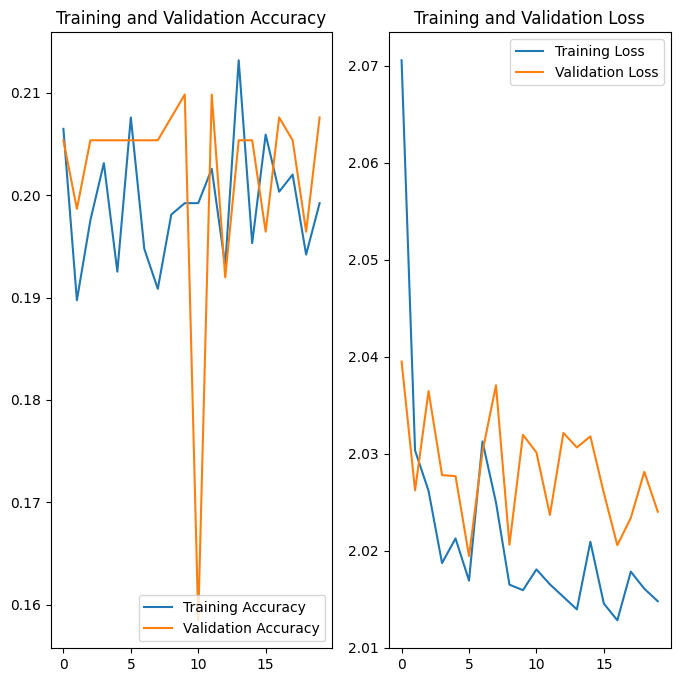

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

>Finding from Second Model
As we can see that now the Training and Validation accuracy are almost in the same level and the highest accuracy achieved is around 60% , this shows the impact of how performing Data Augmentation can improve the model performance
But we can still try to increase the accuracy of the model

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [43]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/01 Dat...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/01 Dat...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/01 Dat...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/01 Dat...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/01 Dat...,actinic keratosis
...,...,...
2235,/content/gdrive/MyDrive/Colab Notebooks/01 Dat...,vascular lesion
2236,/content/gdrive/MyDrive/Colab Notebooks/01 Dat...,vascular lesion
2237,/content/gdrive/MyDrive/Colab Notebooks/01 Dat...,vascular lesion
2238,/content/gdrive/MyDrive/Colab Notebooks/01 Dat...,vascular lesion


<BarContainer object of 9 artists>

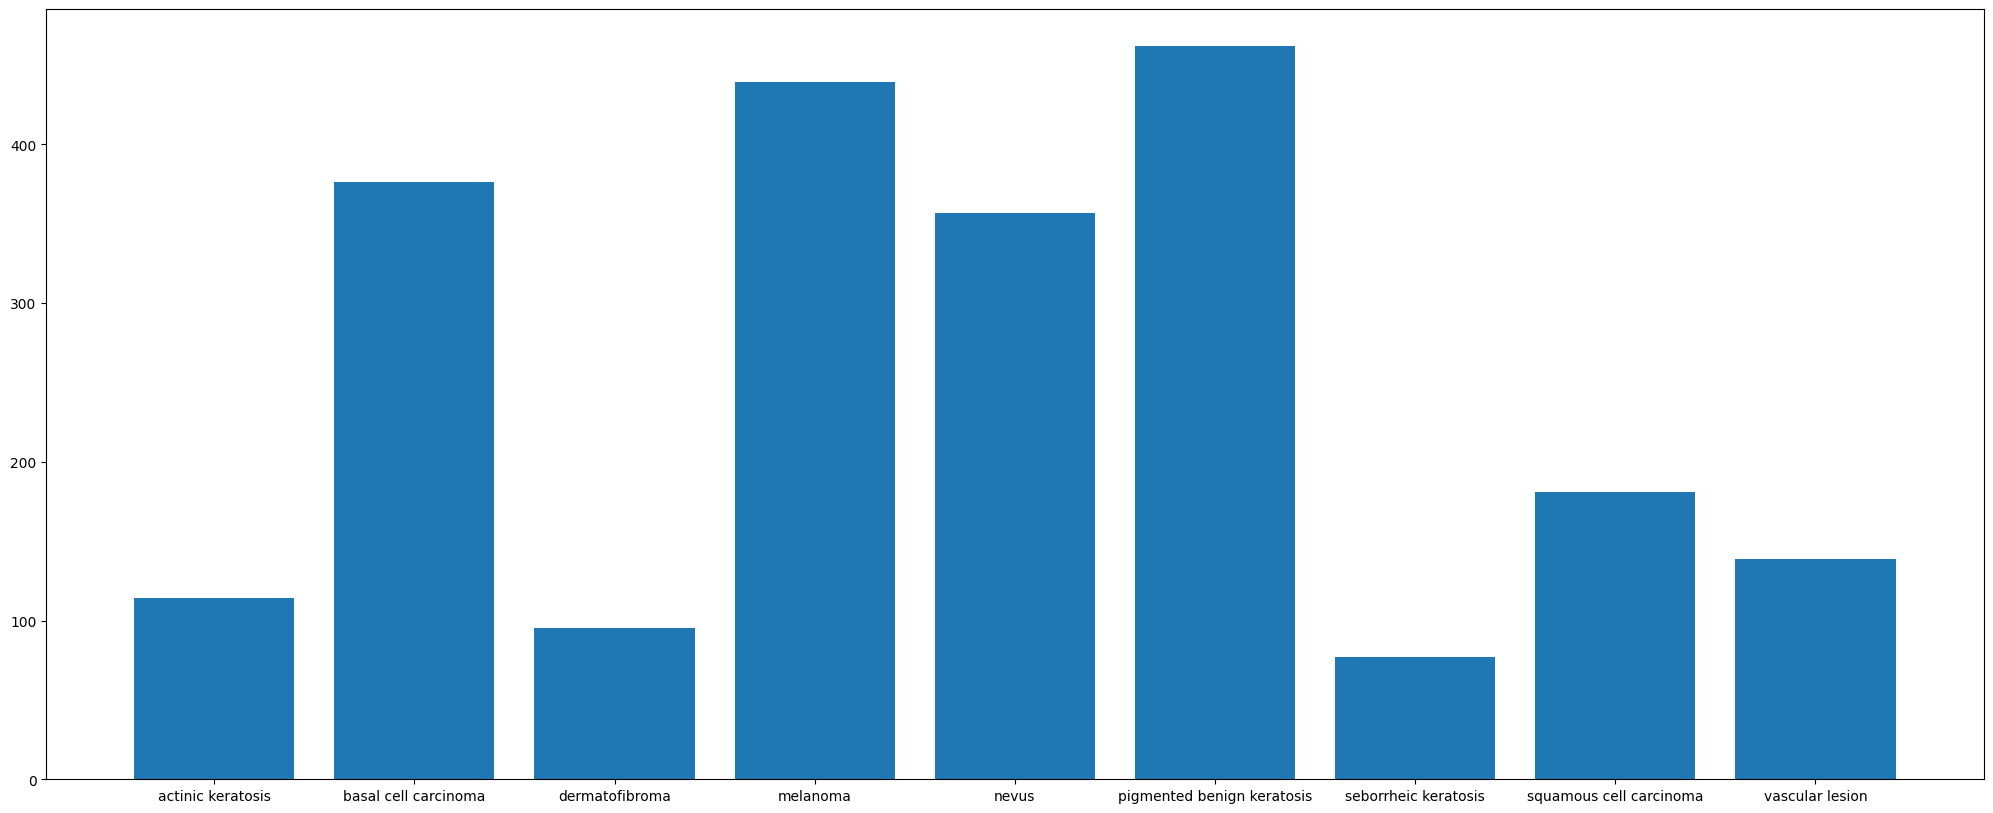

In [44]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
Answer-1 :- Actinic Keratosos and Seborrheic keratosis has least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
Answer-2:- melanoma and pigmented benign keratosis have proprtionate number of classes

In [45]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [46]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [103]:
path_to_training_dataset  = "/content/gdrive/MyDrive/Colab Notebooks/01 Data set AI Ml new/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 2240 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/01 Data set AI Ml new/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DD03DA76CB0>: 100%|██████████| 500/500 [00:39<00:00, 12.52 Samples/s]


Initialised with 2240 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/01 Data set AI Ml new/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DD0432CFB20>: 100%|██████████| 500/500 [00:40<00:00, 12.31 Samples/s]


Initialised with 2240 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/01 Data set AI Ml new/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=962x674 at 0x7DD03F85FA90>: 100%|██████████| 500/500 [00:40<00:00, 12.38 Samples/s]


Initialised with 2240 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/01 Data set AI Ml new/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DD03EB74CD0>: 100%|██████████| 500/500 [00:44<00:00, 11.17 Samples/s]


Initialised with 2240 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/01 Data set AI Ml new/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DD043101600>: 100%|██████████| 500/500 [00:43<00:00, 11.54 Samples/s]


Initialised with 2240 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/01 Data set AI Ml new/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DD0430B5660>: 100%|██████████| 500/500 [00:40<00:00, 12.36 Samples/s]


Initialised with 2240 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/01 Data set AI Ml new/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DD03F880700>: 100%|██████████| 500/500 [00:43<00:00, 11.43 Samples/s]


Initialised with 2240 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/01 Data set AI Ml new/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DD03DA39F60>: 100%|██████████| 500/500 [00:39<00:00, 12.76 Samples/s]


Initialised with 2240 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/01 Data set AI Ml new/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DD0A7755570>: 100%|██████████| 500/500 [00:44<00:00, 11.12 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [104]:
import glob

### Lets see the distribution of augmented data after adding new images to the original training data.

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [105]:
data_dir_train1 = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/01 Data set AI Ml new/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output')
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


In [106]:
for i in class_names:

    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/01 Dat...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/01 Dat...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/01 Dat...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/01 Dat...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/01 Dat...,actinic keratosis
...,...,...
6735,/content/gdrive/MyDrive/Colab Notebooks/01 Dat...,vascular lesion
6736,/content/gdrive/MyDrive/Colab Notebooks/01 Dat...,vascular lesion
6737,/content/gdrive/MyDrive/Colab Notebooks/01 Dat...,vascular lesion
6738,/content/gdrive/MyDrive/Colab Notebooks/01 Dat...,vascular lesion


In [107]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    1390
melanoma                      1322
basal cell carcinoma          1152
nevus                         1045
squamous cell carcinoma        543
vascular lesion                438
actinic keratosis              341
dermatofibroma                 274
seborrheic keratosis           235
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [108]:
batch_size = 32
img_height = 180
img_width = 180

In [109]:
import pathlib
data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/01 Data set AI Ml new/Skin cancer ISIC The International Skin Imaging Collaboration/Train")


In [110]:
data_dir_train1


PosixPath('/content/gdrive/MyDrive/Colab Notebooks/01 Data set AI Ml new/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

#### **Todo:** Create a training dataset

In [111]:
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

2240


In [112]:
data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/01 Data set AI Ml new/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11240 files belonging to 10 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [113]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11240 files belonging to 10 classes.
Using 2248 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [114]:
## your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [115]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [124]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 64)        51264     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                

#### **Todo:**  Train your model

In [116]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


281/281 [==============================] - 76s 256ms/step - loss: nan - accuracy: 0.0546 - val_loss: nan - val_accuracy: 0.0534
Epoch 2/50
281/281 [==============================] - 71s 247ms/step - loss: nan - accuracy: 0.0549 - val_loss: nan - val_accuracy: 0.0534
Epoch 3/50
281/281 [==============================] - 72s 253ms/step - loss: nan - accuracy: 0.0549 - val_loss: nan - val_accuracy: 0.0534
Epoch 4/50
281/281 [==============================] - 71s 247ms/step - loss: nan - accuracy: 0.0549 - val_loss: nan - val_accuracy: 0.0534
Epoch 5/50
281/281 [==============================] - 71s 249ms/step - loss: nan - accuracy: 0.0549 - val_loss: nan - val_accuracy: 0.0534
Epoch 6/50
281/281 [==============================] - 71s 246ms/step - loss: nan - accuracy: 0.0549 - val_loss: nan - val_accuracy: 0.0534
Epoch 7/50
281/281 [==============================] - 71s 247ms/step - loss: nan - accuracy: 0.0549 - val_loss: nan - val_accuracy: 0.0534
Epoch 8/50
281/281 [==================

#### **Todo:**  Visualize the model results

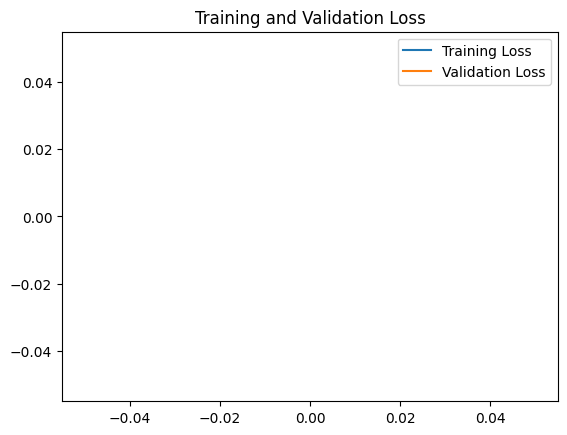

In [133]:

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Text(0.5, 1.0, 'Training and Validation Accuracy')

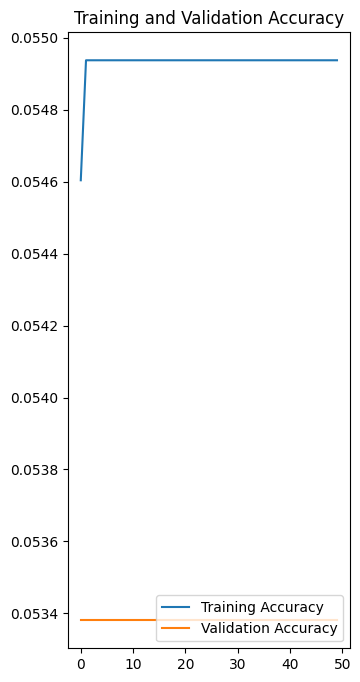

In [132]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


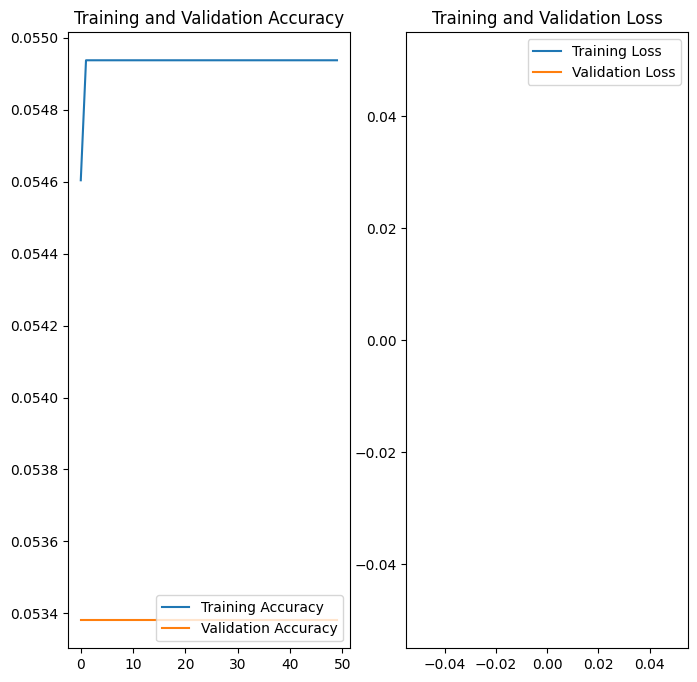

In [136]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



observation:
- We can infer that the Model is fit with a good enough accuracy for both Train and Validation Data of max accuracy around 85% Rectifying the Class Imbalance and performing Data augumentation on the dataset has resulted in a model with higher accuracy and overcoming overfitting This is a good model to be used to predict Skin Cancer using CNN.
-Accuracy on training data has increased by using Augmentor library
-Model is still overfitting
-The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.
-The Model can be further improved by tuning the hyperparameter
